# Clasificación de los datos

En este cuaderno veremos algunas maneras de detectar si existe o no precipitación en los datos del radar. Esto será importante para encontrar datos interesantes en las bases de datos o para realizar una primera aproximación a los avisos. Para elaborar los estadisticos de clasificación necesitaremos un valor que discrimine los datos que contienen precipitación de los que no. 

Para ello importaremos algunas librerías y módulos.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import wradlib as wrl
import warnings 

import Bases_GUI as radar
import utilidades as util

warnings.filterwarnings('ignore')

Elaborar un estadístico requiere cierto conocimiento de los datos. Así que, ¿qué diferencia a una trama de precipitación de una que solo contenga clutter?

Una diferencia clara es que cuando halla precipitación existirá un menor número de píxeles en reflectividad mínima. Podemos aprovechar dicho comportamiento para clasificar los datos. 

In [17]:
def npm(data):
    unique, counts = np.unique(data, return_counts=True)
    diccionario = dict(zip(unique, counts))
    number = diccionario[-31.5]
    factor = data.shape[0] * data.shape[1]
    number = number / factor
    return number

Para probar si el estadístico resulta apropiado necesitaremos probarlo en un conjunto de datos. Para ello traeremos datos de clutter como de precipitación.

In [6]:
ruta = 'C:\Python37\Clutter'
clutterdata = util.dataclass(ruta)
Matriz = util.matriz3d(clutterdata)

In [7]:
ruta = 'C:\Python37\Lluvia'
prepdata = util.dataclass(ruta)
Prec = util.matriz3d(prepdata)

Antes de calcular las estadísticas mostraremos un pequeño GIF de los datos de clutter y de precipitación.

<img src="Clutterf.gif">
Datos de clutter. Estos corresponden a data no continua recolectada por varios días durante el mes de mayo del 2019.

Los datos de precipitación en cambio, fueron tomados el día 14/05/2019 durante la mañana y presentan continuidad temporal. 
<img src="camila.gif">

Ya con los datos procedemos a calcular las estadísticas.

In [18]:
npm_clutter = [npm(Matriz[..., i]) for i in range(len(clutterdata))]
npm_precip = [npm(Prec[..., i]) for i in range(len(prepdata))]

Presentamos los resultados. Como solamente tenemos un eje, el otro lo usaremos como etiquetas de nuestros datos. Le corresponderá el valor de `0` a la precipitación y `1` al valor del clutter. Esto será una pequeña convención de aquí en adelante. 

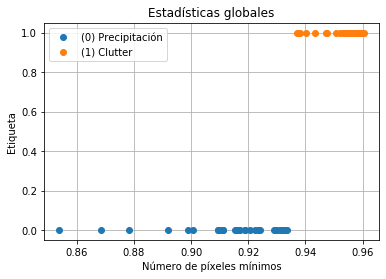

In [19]:
fig = plt.figure()
plt.title('Estadísticas globales')
plt.xlabel('Número de píxeles mínimos')
plt.ylabel('Etiqueta')
plt.plot(npm_precip, np.zeros_like(npm_precip), 'o', label='(0) Precipitación')
plt.plot(npm_clutter, np.ones_like(npm_clutter), 'o', label='(1) Clutter')
plt.legend(loc='upper left')
plt.grid()

Vemos como los datos de precipitación tienden a tener valores más pequeños que los datos de clutter. Sin embargo, parece no haber una diferencia clara. O al menos muy poca. 

Si uno se fija en el GIF de lluvia, los últimos datos presentan un comportamiento un tanto anómalo para una tormenta. Todos los datos indican una velocidad del viento radial hacia el oeste. Pero estos no se mueven. La verdad cuesta distinguir si son clutter o son auténtica precipitación si no tenemos más información. Hace falta más eventos de precipitación para decir si eso es un fenoméno recurrente despúes de la precipitación o que representa esa región sin movimiento. 

Podríamos plantear un límite entre los datos máximos y mínimos de ambos conjuntos. 

In [23]:
npm_clutter = np.array(npm_clutter)
npm_precip = np.array(npm_precip)
limite = (npm_clutter.min() + npm_precip.max()) / 2
print('Límite: {0:.3}'.format(limite))

Límite: 0.935


Redibujamos el gráfico, esta vez con la línea divisoria.

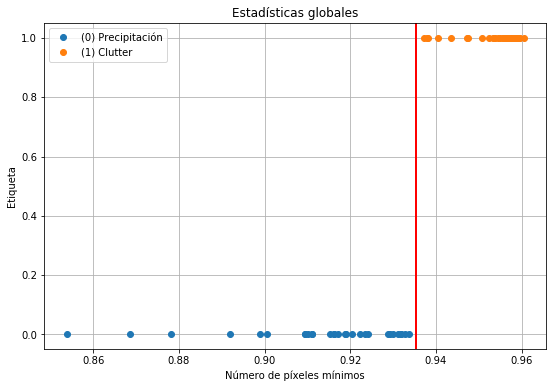

In [27]:
fig = plt.figure(figsize=(9,6))
plt.title('Estadísticas globales')
plt.xlabel('Número de píxeles mínimos')
plt.ylabel('Etiqueta')
plt.plot(npm_precip, np.zeros_like(npm_precip), 'o', label='(0) Precipitación')
plt.plot(npm_clutter, np.ones_like(npm_clutter), 'o', label='(1) Clutter')
plt.axvline(x = limite, linewidth=2, color='r')
plt.legend(loc='upper left')
plt.grid()

Con ello, ya tenemos un estadístico. Pero es necesario probar otras opciones.

Para ello veremos las distribuciones de los datos, especificamente su histograma.

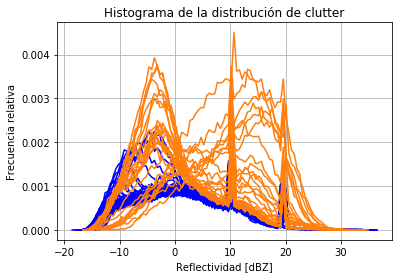

In [32]:
for i in range(len(clutterdata)): 
    unique, counts = np.unique(Matriz[..., i], return_counts=True)
    counts = counts / (360 * 1000 )
    plt.plot(unique[1:], counts[1:],color = 'b',label='Clutter')
for j in range(len(prepdata)):
    unique, counts = np.unique(Prec[..., j], return_counts=True)
    counts = counts / (360 * 1000 )
    plt.plot(unique[1:], counts[1:],color = 'tab:orange',label='Lluvia')
plt.title('Histograma de la distribución de clutter')
plt.xlabel('Reflectividad [dBZ]')
plt.ylabel('Frecuencia relativa')
plt.grid()

**Nota:** Este dibujo no toma en cuenta los valores de reflectividad mínima(-31.5 dBZ) porque de hacerlo el resto de frecuencias no se notaría. 

Observe que los datos de clutter suelen tener picos en valores de reflectividad de 10 dBZ o 20 dBZ. El comportamiento de los datos de clutter para valores mayores de cero suele ser estable, mientras que para el caso de valores precipitación claramente no existe tendencia.

Podemos tomar ese comportamiento como referencia y calcular el error de las distribuciones para clasificar los datos.

Para ello debemos organizar el histograma en regiones, pues la comprobación por valor - valor puede tener muchos inconvenientes al ser una distribución de valores discretos. 

Antes de colocar la función, calcularemos un valor de ejemplo.

In [40]:
hist, binedges = np.histogram(Matriz[..., 0], bins=20, range = (-32.,40.), density=False)

Mostramos el intervalo de trabajo que para nuestra definición es de 20 elementos y comprende valores entre -32 y 40 dBZ. Alguien podría preguntarse que pasa con valores superiores, dado que el espectro abarca desde -31.5 hasta 95.5 dBZ. Sucede que valores tan altos de reflectividad sólo podrían estar asociados a precipitaciones muy severas. Si hubiese un valor de reflectividad tan alto, lo clasificaríamos como precipitación sin duda. 

In [41]:
binedges

array([-32. , -28.4, -24.8, -21.2, -17.6, -14. , -10.4,  -6.8,  -3.2,
         0.4,   4. ,   7.6,  11.2,  14.8,  18.4,  22. ,  25.6,  29.2,
        32.8,  36.4,  40. ])

Dado que el patrón de clutter es consistente para valores mayores que `0`, cortaremos el resto del espectro. Teniendo eso en cuenta, ya estamos listos para definir la función. 

Calculamos la referencia usando los valores del consolidado

In [49]:
ref, binedges = np.histogram(Matriz, bins=20, range = (-32.,40.), density=False)
ref = ref / len(clutterdata)

In [58]:
def error(data, ref):
    hist, binedges = np.histogram(data, bins=20, range = (-32.,40.), density=False)
    tmp = abs(hist - ref)
    #tmp[12:] = 0
    return tmp.sum()

Note que esta función se puede romper mucho más fácil, si resulta ser un buen indicador se abstraerá para evitar cualquier incoveniente. 

In [59]:
error_clutter = [error(Matriz[..., i], ref) for i in range(len(clutterdata))]
error_precip = [error(Prec[..., i], ref) for i in range(len(prepdata))]
error_clutter, error_precip = np.array(error_clutter), np.array(error_precip)

Mostramos los resultados

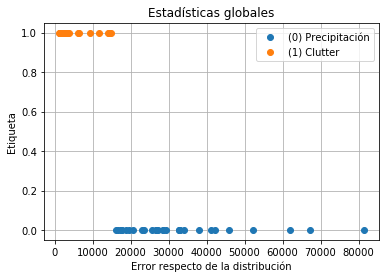

In [60]:
fig = plt.figure()
plt.title('Estadísticas globales')
plt.xlabel('Error respecto de la distribución')
plt.ylabel('Etiqueta')
plt.plot(error_precip, np.zeros_like(error_precip), 'o', label='(0) Precipitación')
plt.plot(error_clutter, np.ones_like(error_clutter), 'o', label='(1) Clutter')
plt.legend(loc='upper right')
plt.grid()

Vemos los límites de separación. 

In [61]:
print('Máximo indicador en clutter: {}'.format(error_clutter.max()))
print('Mínimo indicador en precipitación: {}'.format(error_precip.min()))

Máximo indicador en clutter: 14942.222222222239
Mínimo indicador en precipitación: 16072.349206349221


Pese a que no lo parece si existe diferencia entre los conjuntos. Además este indicador remarca más la diferencia.

Ambos indicadores son insensibles a la distribución espacial de los datos, por lo que un mejor estimador debería considerarlos. Usaremos como tal una estimación del área y el valor de la tasa de precipitación. 

In [63]:
def tejina(data):
    tmp = wrl.zr.z_to_r(wrl.trafo.idecibel(data))
    beh = np.sum(tmp * util.area_matriz()/1000000) # Entre 1000 000 para indicar el área en km
    return beh

In [66]:
tejina_clutter = [tejina(Matriz[..., i]) for i in range(len(clutterdata))]
tejina_precip = [tejina(Prec[..., i]) for i in range(len(prepdata))]
tejina_clutter, tejina_precip = np.array(tejina_clutter), np.array(tejina_precip)

Mostramos los resultados.

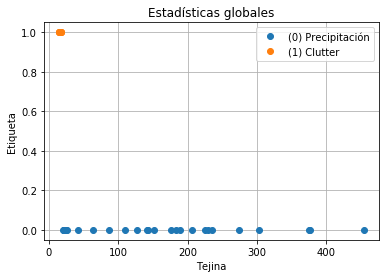

In [69]:
fig = plt.figure()
plt.title('Estadísticas globales')
plt.xlabel('Tejina')
plt.ylabel('Etiqueta')
plt.plot(tejina_precip, np.zeros_like(tejina_precip), 'o', label='(0) Precipitación')
plt.plot(tejina_clutter, np.ones_like(tejina_clutter), 'o', label='(1) Clutter')
plt.legend(loc='upper right')
plt.grid()

Veremos los límites entre ambos conjuntos. 

In [72]:
print('Máximo indicador en clutter: {0:.3}'.format(tejina_clutter.max()))
print('Mínimo indicador en precipitación: {0:.3}'.format(tejina_precip.min()))

Máximo indicador en clutter: 16.8
Mínimo indicador en precipitación: 20.5


Veamos los valores del indicador tejina para clutter. 

In [73]:
tejina_clutter

array([15.99520337, 15.34609505, 15.43760239, 15.49985201, 15.84812204,
       15.26714579, 16.23002627, 15.64402059, 15.40586732, 15.28340356,
       16.23185955, 15.27279718, 15.19428119, 15.10285547, 15.04910458,
       15.00602377, 16.7717261 , 16.79636858, 16.6268589 , 16.41414985,
       16.05071999, 15.82332815, 16.03645398, 15.70019475, 15.58850588,
       15.57582839, 15.51934699, 15.47047217, 15.43327566, 15.44169036,
       15.44729671, 15.42201453, 15.39198935, 15.42292985, 15.55587088,
       15.48799638, 15.4510478 , 15.45145742, 15.451277  , 15.45001804,
       15.42820424, 15.40155428, 15.42244395, 15.40370727, 15.41875228,
       15.39631413, 15.35588342, 15.58301805, 15.53664728, 15.51150967,
       15.54240837, 15.57770244, 15.53372903, 15.52761742, 15.56336103,
       15.54362013, 15.52798574, 15.57020367, 15.4184846 , 15.65611664,
       15.60992069, 15.5726269 , 15.58175832])

Y para precipitación

In [75]:
tejina_precip

array([453.92495693, 376.17486937, 375.44274853, 273.39394305,
       234.76429657, 225.4119658 , 205.83106705, 188.46915172,
       176.21099214, 140.81435403, 302.94214948, 229.90118716,
       182.41548258, 150.94307802, 142.40355079, 126.97848217,
       110.21148838,  86.64782498,  63.07665375,  42.45440652,
        26.48822305,  22.35081087,  23.93807507,  22.01114462,
        21.07081757,  22.5090566 ,  22.05750018,  22.31084912,
        20.5345958 ])

El cambio usando el indicador tejina se nota más que en los casos anteriores bajo una comparación relativa. 

En base al conjunto de datos analizado se puede escoger el método que decidas conveniente y su límite correspondiente. Si crees que los últimos datos de precipitación en realidad no lo son, puedes usar umbrales más altos para clasificarlos como clutter. O si lo crees conveniente, crea tu indicador y validalo usando los datos. Recuerda que dado que esto está basado en los datos recolectados, solo es aplicable para el radar PIUXX. No lo apliques en otras condiciones sin antes haberlo probado. 